# Data Augmentation

So far, we have selected a model architecture that vastly improves the model's performance, as it is designed to recognize important features in the images. The validation accuracy is still lagging behind the training accuracy, which is a sign of overfitting (the model is getting confused by things it has not seen before when it tests against the validation dataset.

In order to teach our model to be more robust when looking at a new data, we are going to programatically increase the size and variance in our dataset. This is known as **data augmentation**, a useful technique for many deep learning applications.

The increase in size gives the model more images to learn from while training. The increase in variance helps the model ignore unimportant features and select only teh features that are truly important in classification, allowing to generalize better.

## Preparing the Data

In [1]:
import tensorflow.keras as keras
import pandas as pd

In [2]:
# Load in data from CSV files
train_df = pd.read_csv('Data/mnist/sign_mnist_train.csv')
valid_df = pd.read_csv('Data/mnist/sign_mnist_valid.csv')

In [3]:
# Separate out target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

In [4]:
# Separate out image vectors
x_train = train_df.values
x_valid = valid_df.values

In [5]:
# Turn scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

In [6]:
# Normalize image data
x_train = x_train/255
x_valid = x_valid/255

In [7]:
# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)

## Model Creation

Notice: this model architecture is the same as in the previous notebook.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, MaxPool2D, Flatten,
                                     Dropout, BatchNormalization)

In [9]:
model = Sequential()

In [10]:
model.add(Conv2D(75, (3,3), strides=1, padding='same',
                 activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(50, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(25, (3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation='softmax'))

## Data Augmentation

Keras comes with an image augmentation class caled `ImageDataGenerator`. It accepts a series of options for augmenting your data.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
datagen = ImageDataGenerator(
    rotation_range = 10, # randomly rotates images in the range (degrees, 0 to 180)
    zoom_range=0.1, # randomly zoom image
    width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1, # randomly shift images vertically (fraction of total height)
    horizontal_flip = True, # randomly flip images horizontally
    vertical_flip = False, # don't randomly flip images vertically 
)

Our dataset is pictures of hands signing the alphabet. We want to flip images horizontally, but not vertically because if we want to use this model to classify hand images, it is unlikely that those hands are going to be upside-down, but they might be left-handed. This kind of domain-specific reasoning can help make good decisions for your own deep learning applications.

## Batch Size

Another benefit of the `ImageDataGenerator` is that it batches our data so that our model can train on a random sample.
 
If the model is truly random, meaning that the data is properly shuffled so it is fair like a deck of cards, then our sample can do a good job representing all of our data even though it is a tiny fraction of the population. For each step of the training, the model will be dealt a new batch.

In practice, a batch size of 32 and 64 does well.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

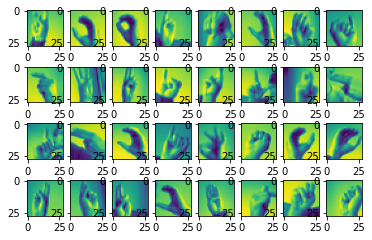

In [14]:
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y= img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))

## Fitting the Data to the Generator

The generator must be fit on the training dataset.

In [15]:
datagen.fit(x_train)

## Compiling the Model

In [16]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## Training with Augumentation

When using an image data generator with Keras, a model trains a bit differently: instead of just passing the `x_train` and `y_train` datasets into the model, we pass the generator in, calling the generator's *flow* method. This causes the images to get augmented live and in memory right before they are passed into the model training.

Generators can supply an indefinite amount of data, and when we use them to train our data, we need to explicitly set how long we want each epoch to run, or else the epoch will go in indefinitely, with the generator creating an indefinite number of augmented images to provide the model.

We explicitly set how long we want each epoch to run using the `steps_per_epoch` named argument. Because `steps * batch_size = number_of_images_trained in an epoch` a common practice, that will use here, is to set the number of steps equal to non-augmented dataset size divided by the batch_size (which has a default value of 32).

In [17]:
model.fit(img_iter, epochs=20, steps_per_epoch=len(x_train)/batch_size,
          validation_data = (x_valid, y_valid))
# Steps_per_epoch run same number of steps we would like if we were not using a generator

Epoch 1/20
857/857 [==============================] - 54s 62ms/step - loss: 1.0808 - accuracy: 0.6504 - val_loss: 1.9827 - val_accuracy: 0.5192
Epoch 2/20
857/857 [==============================] - 52s 60ms/step - loss: 0.2956 - accuracy: 0.8981 - val_loss: 0.2099 - val_accuracy: 0.9282
Epoch 3/20
857/857 [==============================] - 53s 62ms/step - loss: 0.1895 - accuracy: 0.9367 - val_loss: 0.5342 - val_accuracy: 0.8303
Epoch 4/20
857/857 [==============================] - 58s 67ms/step - loss: 0.1413 - accuracy: 0.9529 - val_loss: 0.1944 - val_accuracy: 0.9413
Epoch 5/20
857/857 [==============================] - 55s 64ms/step - loss: 0.1248 - accuracy: 0.9603 - val_loss: 0.1732 - val_accuracy: 0.9438
Epoch 6/20
857/857 [==============================] - 52s 61ms/step - loss: 0.1022 - accuracy: 0.9664 - val_loss: 0.0253 - val_accuracy: 0.9930
Epoch 7/20
857/857 [==============================] - 56s 66ms/step - loss: 0.0910 - accuracy: 0.9720 - val_loss: 0.1539 - val_accuracy:

Notice: The validation accuracy is higher, and more consistent than in the model in previous notbook. This means that our model is no longer overfitting in the way it was before; it generalizes better, making better predictions on new data.

## Saving the Model

Now that we have well-trained model, we will want to deploy it to perform inference on new images.

It is common, once we have a trained model that we are happy with to save it to disk.

Saving the model in Keras is quite easy using the `save` method. There are also different formats. In the next notebook, we will load the model and use it to read new sign language pictures.

In [18]:
model.save('asl_model')

INFO:tensorflow:Assets written to: asl_model/assets


In this section we used Keras to augument our dataset, the result being a trained model with less overfitting and excellent validation image results.

In [19]:
# Clear the GPU memory
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}